In [3]:
import pandas as pd
import numpy as np
import os
import time
# import copy
# import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# from graphviz import Digraph
# from joblib import Parallel, delayed
# from scipy import stats

# from survivors import metrics as metr
# from survivors import constants as cnt
# from survivors import criteria as crit
# from numba import njit, jit, int32, float64
# from lifelines import KaplanMeierFitter, NelsonAalenFitter

# import survivors.datasets as ds

# import cProfile
# import pstats

# %load_ext line_profiler
# %load_ext scalene

import warnings
warnings.filterwarnings("ignore")

Matplotlib is building the font cache; this may take a moment.


In [3]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

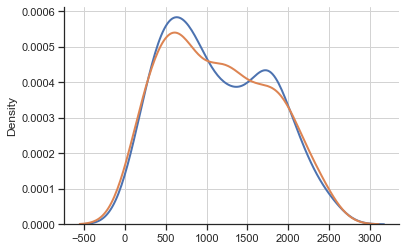

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

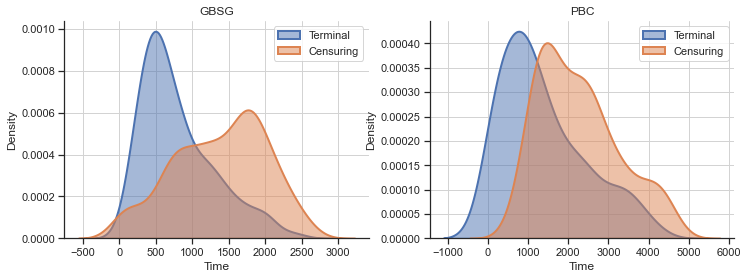

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
sns.kdeplot(y["time"][y["cens"] == True], label="Terminal", ax=axes[0], linewidth=2, alpha=.5, fill=True)
sns.kdeplot(y["time"][y["cens"] == False], label="Censuring", ax=axes[0], linewidth=2, alpha=.5, fill=True)
axes[0].set_xlabel("Time")
axes[0].set_title("GBSG")
axes[0].legend()

X, y, features, categ, sch_nan = ds.load_pbc_dataset()
sns.kdeplot(y["time"][y["cens"] == True], label="Terminal", ax=axes[1], linewidth=2, alpha=.5, fill=True)
sns.kdeplot(y["time"][y["cens"] == False], label="Censuring", ax=axes[1], linewidth=2, alpha=.5, fill=True)
axes[1].set_xlabel("Time")
axes[1].set_title("PBC")
axes[1].legend()

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]
# plt.savefig("./DatasetDensity(ROTT2,WUHAN).png")

In [3]:
X, y, features, categ, sch_nan = ds.load_smarto_dataset()

In [4]:
from survivors.tree import CRAID

custom_params = {"font.size": 16, "axes.labelsize": 16, "xtick.labelsize": 16, "ytick.labelsize": 16,
                 "axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 2, 
     'leaf_model': 'base', 'min_samples_leaf': 0.02, 'signif': 1, 'woe': True}

tree = CRAID(**p)
tree.fit(X, y)

dot = tree.visualize(mode="kde", target="time")
dot
plt.savefig("./CRAID.png")

<Figure size 432x288 with 0 Axes>

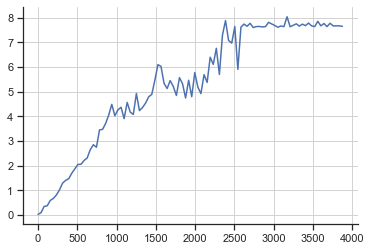

In [22]:
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 1, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0,
     'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 1, 'signif': 1, 'woe': True}

ts = []
for s in np.linspace(1, 3873, 100).astype(int):
    time_start = time.time()
    p["depth"] = p_
    tree = CRAID(**p)
    tree.fit(X_tr[:s], y_tr[:s])
    ts.append(time.time() - time_start)
plt.plot(np.linspace(1, 3873, 100).astype(int), ts)

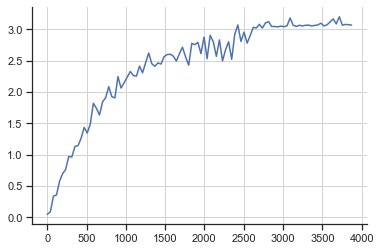

In [21]:
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 1, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0,
     'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 1, 'signif': 1, 'woe': True}

ts = []
for s in np.linspace(1, 3873, 100).astype(int):
    time_start = time.time()
    p["depth"] = p_
    tree = CRAID(**p)
    tree.fit(X_tr[:s], y_tr[:s])
    ts.append(time.time() - time_start)
plt.plot(np.linspace(1, 3873, 100).astype(int), ts)

In [4]:
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 15, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0,
     'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 0.01, 'n_jobs': 20, 'n_jobs_loop': 1, 'signif': 1, 'woe': True}

time_start = time.time()
tree = CRAID(**p)
tree.fit(X_tr, y_tr)
print(time.time() - time_start)

auprc_by_obs_HO = metr.auprc(y_tr, y_HO, tree.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)
ibsrm_by_obs_HO = metr.ibs_remain(y_tr, y_HO, tree.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)
print(auprc_by_obs_HO)
print(ibsrm_by_obs_HO)

9.821116209030151
[0.99998    0.99998    0.99569204 ... 0.98217849 0.97313351 0.06258666]
[0.00000000e+00 0.00000000e+00 2.08680984e-05 ... 2.79317962e-04
 1.10339743e-03 6.21636290e-01]


In [5]:
dot = tree.visualize(mode="hist", target="time")
dot

### DATASET CHARACTERISTICS DEMONSTRATION

========== GBSG ==========


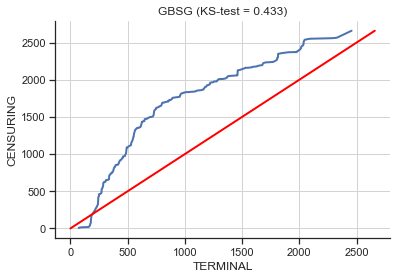

========== PBC ==========


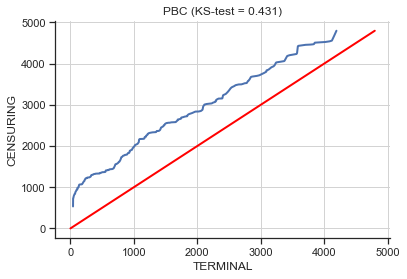

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['max_' + c] = df_agg[c].apply(np.nanmax)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + 

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.6.2-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

========== WUHAN ==========


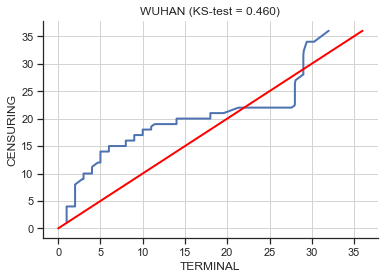

========== smarto ==========


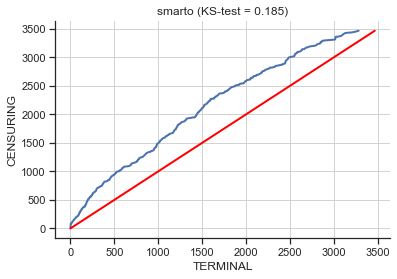

========== rott2 ==========


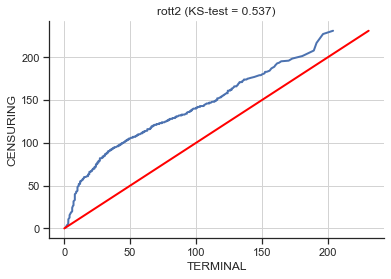

========== support2 ==========


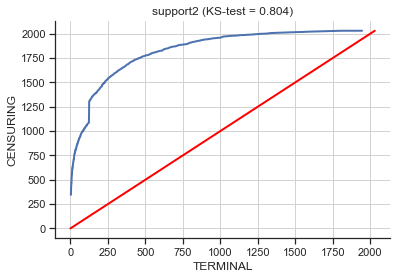

In [13]:
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

DATASETS_LOAD = {
    "GBSG": ds.load_gbsg_dataset,
    "PBC": ds.load_pbc_dataset,
    "WUHAN": ds.load_wuhan_dataset,
    "smarto": ds.load_smarto_dataset,
    "rott2": ds.load_rott2_dataset,
    "support2": ds.load_support2_dataset
}

def test_normal(sample):
    print("shapiro:", stats.shapiro(sample).pvalue)
    ad = stats.anderson(sample, 'norm')
    print("anderson:", ad.statistic < ad.critical_values[np.where(ad.significance_level == 2.5)][0])
    np.random.seed(42)
    print("kstest:", stats.kstest(sample, 
                       np.random.normal(np.mean(sample), 
                                        np.std(sample), 100000), method="exact").pvalue)

res = pd.DataFrame([], columns=["Dataset", "InfTest", "UnPropSize", "UnPropFeatures"])
for name, loader in DATASETS_LOAD.items():
    X, y, features, categ, sch_nan = loader()
    
    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    df = df.fillna(0).replace(np.nan, 0).replace(np.inf, 0)
    print("="*10, name, "="*10)
    #print("TERMINAL")
    #test_normal(df[df["cens"] == 1]["time"])
    #print("CENSURING")
    #test_normal(df[df["cens"] == 0]["time"])
    #print(f'kstest:{stats.kstest(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"]).pvalue:.3e}')
    #print(f'Welch’s t-test:{stats.ttest_ind(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"], equal_var=False).pvalue:.3e}')
    #print(f'mannwhitneyu:{stats.mannwhitneyu(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"]).pvalue:.3e}')
    plt.plot(np.quantile(df[df["cens"] == 1]["time"], np.linspace(0, 1, 1000)),
                np.quantile(df[df["cens"] == 0]["time"], np.linspace(0, 1, 1000)))
    plt.plot([0, df["time"].max()], [0, df["time"].max()], c="red")
    plt.xlabel("TERMINAL")
    plt.ylabel("CENSURING")
    plt.title(f"{name} (KS-test = {stats.kstest(df[df['cens'] == 1]['time'], df[df['cens'] == 0]['time'], method='exact').statistic:.3f})")
    plt.savefig(f"./{name}_qq.png")
    plt.show()

    cph = CoxPHFitter(penalizer=0.000001).fit(df, 'time', 'cens')  # strata=[feat]
    results = proportional_hazard_test(cph, df, time_transform='km')
    unprop_features = {n:p for n, p in zip(results.name, results._p_value) if p < 0.05}
    a = pd.DataFrame([{"Dataset":name, 
                      "InfTest":stats.kstest(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"], method="exact").pvalue,
                      "InfTestStat":stats.kstest(df[df["cens"] == 1]["time"], df[df["cens"] == 0]["time"], method="exact").statistic,
                      "UnPropSize": len(unprop_features),
                      "UnPropFeatures": dict(sorted(unprop_features.items(), key=lambda item: item[1])[:5])}])
    res = pd.concat([res, a], ignore_index=True)
res.to_csv(os.path.join(f"./Dataset_EDA.csv"), sep="&")

### Informative censuring comparison

In [13]:
!pip3 install survivors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 6.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 5.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 3.9 MB/s eta 0:00:00


In [15]:
import survivors.datasets as ds
import survivors.constants as cnt
from survivors.external.nonparametric import KaplanMeier

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

In [16]:
X.shape[0]*0.05, X.shape[0]*0.3

(34.300000000000004, 205.79999999999998)

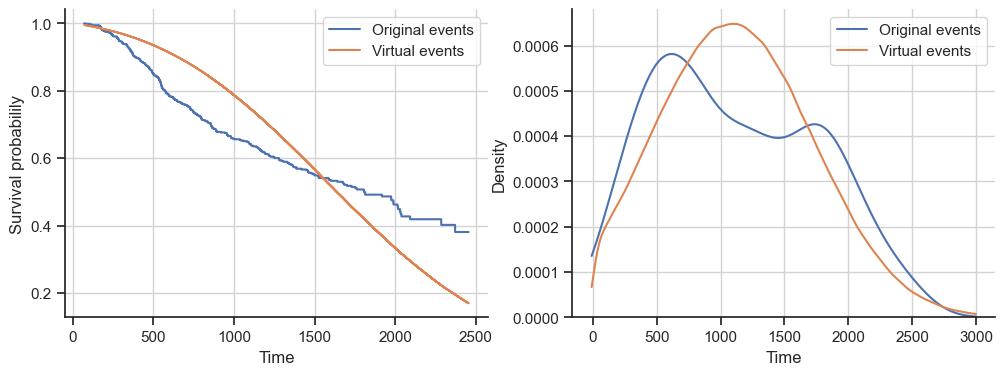

In [42]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfter1(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.normal(np.median(durations), np.std(durations), 1000000)  # / np.sqrt(2)
        self.events = np.random.choice(right_censor, size=1000000, replace=True)
        self.durs = np.hstack([durations.copy(), self.durs])
        self.events = np.hstack([right_censor.copy(), self.events])
        
#         self.durs = np.random.normal(np.mean(durations), np.std(durations)/np.sqrt(2), 1000)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)

#         self.durs = np.vstack([np.random.choice(durations, size=1000, replace=True), 
#                                np.random.choice(durations, size=1000, replace=True)]).mean(axis=0)
#         self.events = np.random.choice(right_censor, size=1000, replace=True)
        
        self.events = self.events[self.durs > 0]
        self.durs = self.durs[self.durs > 0]
        
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfter1()
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

# ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
# ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

# auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
# auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events", clip=[-10, 3000])
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events", clip=[-10, 3000])
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
# print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
# print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")
plt.savefig('./GBSG_MULTI_KM_DENS_NORM.png', dpi=300, bbox_inches='tight')

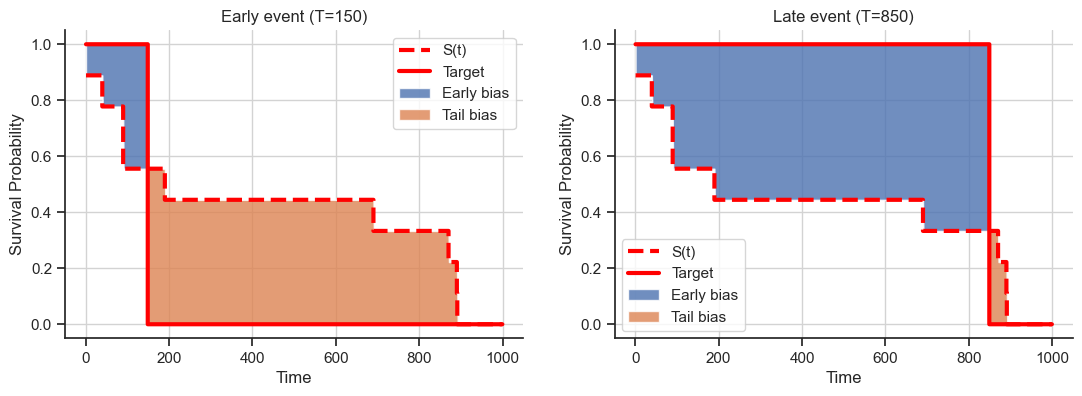

In [12]:
def split_time_to_bins(time, event=None, apr_times=None, apr_events=None):
    if apr_times is None:
        return np.searchsorted(np.arange(int(time.min() - 1), int(time.max() + 1)), time)
    return np.searchsorted(np.arange(int(apr_times.min() - 1), int(apr_times.max() + 1)), time)

def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist

def plot_event_with_sf(bins, sf, e_time, ax, has_label=True):
    if not(bins is None):
        ax.step(bins, sf, color="red", linestyle="--", linewidth=3, label="S(t)")
    ind_early = np.where(bins < e_time)[0]
    ind_late = np.where(bins >= e_time)[0]
    ax.step(bins, np.hstack([np.ones_like(ind_early), np.zeros_like(ind_late)]), linewidth=3, color="red", label="Target")
    ax.fill_between(bins[ind_early], sf[ind_early], 1, alpha=0.8, label="Early bias") 
    ax.fill_between(bins[ind_late], sf[ind_late], 0, alpha=0.8, label="Tail bias")  # , hatch = '/')
    ax.set_ylabel("Survival Probability")
    ax.set_xlabel("Time")
    # ax.set_ylabel("Вероятность выживания", fontsize=16, fontname="Times New Roman")
    # if has_label:
        # ax.set_xlabel("Время", fontsize=16, fontname="Times New Roman")
    ax.legend()

def visualize_filled(time, cens, bins=None):
    if bins is None:
        bins = np.arange(time.min() - 1, time.max())
    t1 = split_time_to_bins(time, bins)
    bins1 = split_time_to_bins(bins, bins)
    max_bin = bins1.max()
    time_hist, cens_hist = get_sa_hists(t1, cens, minlength=max_bin + 2)
    
    c_time = np.cumsum(time_hist[::-1])[::-1]
    sf = np.cumprod((1.0 - cens_hist / (c_time + 1)))
    sf[c_time == 0] = 0.0
    
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    plot_event_with_sf(bins, sf[1:-1], 150, axes[0], has_label=False)
    plot_event_with_sf(bins, sf[1:-1], 850, axes[1])
    axes[0].set_title(f"Early event (T={150})")
    axes[1].set_title(f"Late event (T={850})")
    # axes[0].set_title(f"Ранее событие (T={150})", fontsize=16, fontname="Times New Roman")
    # axes[1].set_title(f"Позднее событие (T={850})", fontsize=16, fontname="Times New Roman")
    #plt.show()
    
a = np.array([10, 50, 100, 100, 200, 700, 880, 900])
visualize_filled(a, np.ones_like(a), np.arange(1, 1000))
plt.savefig('./InterpretEarlyLate.png', dpi=300, bbox_inches='tight')